## Notebook for Running Experiments on CovType Data Set

In [1]:
from typing import List
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import sys

sys.path.append(os.path.dirname(os.getcwd()))

import scipy
import pickle
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from labellines import labelLines
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score

import nannyml as nml
from test_harness.datasets.dataset import Dataset

from river import drift

import random
from sklearn.metrics import roc_auc_score, roc_curve

from urllib.request import urlopen
from sklearn.preprocessing import LabelEncoder

In [3]:
from  test_harness.experiments.dde_experiment import DDEffectExperiment
from test_harness.experiments.baseline_experiment import BaselineExperiment

In [4]:
import warnings
warnings.filterwarnings("ignore")

## Load Data

#### Insect dataset

1000 train originally

In [5]:
full_df = pd.read_csv("../data/insects_full.data", header=None)#.rename(columns={'period': 'period_original'})
full_df.columns = [f'feat_{c+1}' for c in full_df.columns]
full_df = full_df.rename(columns={full_df.columns[-1]: 'class'})

In [6]:
full_df

,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_192,feat_193,feat_194,feat_195,feat_196,feat_197,feat_198,feat_199,feat_200,class
0,0.008025,0.014296,0.012436,0.012884,0.011645,0.011120,0.009875,0.008933,0.007779,0.006801,...,0.001997,0.002404,0.002873,0.003257,0.003767,0.004020,0.004582,0.004522,0.005381,3
1,0.001678,0.002237,0.001822,0.001860,0.001540,0.001875,0.002031,0.002105,0.001902,0.001857,...,0.003370,0.003999,0.004597,0.005053,0.005758,0.006159,0.006886,0.006614,0.007420,3
2,0.000182,0.000363,0.000375,0.000699,0.000940,0.001272,0.001663,0.001953,0.002331,0.002553,...,0.008477,0.009437,0.009902,0.009649,0.008894,0.008001,0.008250,0.008525,0.008820,3
3,0.003522,0.006619,0.005727,0.005593,0.004897,0.004824,0.004742,0.004629,0.004141,0.003831,...,0.000907,0.001009,0.001442,0.002044,0.002830,0.003368,0.004072,0.004118,0.004759,3
4,0.004392,0.006899,0.005102,0.005211,0.004720,0.004711,0.004321,0.004206,0.004136,0.004373,...,0.002569,0.002711,0.002845,0.002907,0.002993,0.002925,0.002984,0.002718,0.002878,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86395,0.000149,0.000179,0.000122,0.000123,0.000099,0.000111,0.000092,0.000099,0.000094,0.000083,...,0.001408,0.001759,0.002691,0.003631,0.004308,0.003796,0.003359,0.002965,0.005204,3
86396,0.000533,0.001133,0.001245,0.001588,0.001927,0.002283,0.002571,0.002877,0.002972,0.002971,...,0.000411,0.000486,0.000564,0.000596,0.000649,0.000650,0.000755,0.000773,0.001106,3
86397,0.007268,0.011191,0.007570,0.006760,0.005072,0.004677,0.003920,0.003445,0.002537,0.001724,...,0.000536,0.000584,0.000637,0.000674,0.000733,0.000749,0.000827,0.000802,0.000957,3
86398,0.000005,0.000009,0.000008,0.000008,0.000007,0.000007,0.000008,0.000011,0.000014,0.000016,...,0.000185,0.000111,0.000064,0.000037,0.000022,0.000015,0.000010,0.000007,0.000008,1


In [7]:
# sns.heatmap(full_df.corr())

In [8]:
#full_df['class'] = np.where(full_df['class']=='UP', 1, 0)

In [9]:
cat_features = []

In [10]:
numeric_features = full_df.columns

In [11]:
# model_cicids = RandomForestClassifier(n_estimators=5, random_state=42, max_depth=5)
# param_grid = {"clf__n_estimators": [5], "clf__max_depth": [5]}

              precision    recall  f1-score   support

           1       0.99      0.44      0.61     28749
           2       1.00      0.96      0.98     28756
           3       0.41      1.00      0.58     11615

    accuracy                           0.75     69120
   macro avg       0.80      0.80      0.72     69120
weighted avg       0.90      0.75      0.76     69120

Accuracy: 0.7523292824074074


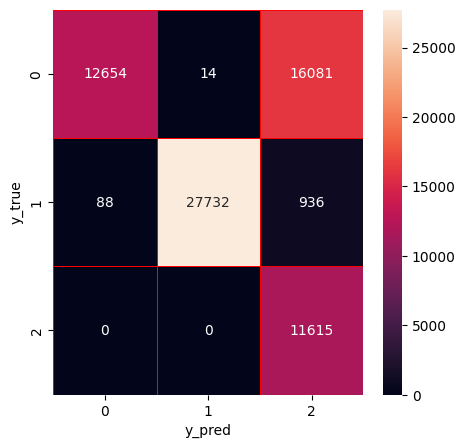

In [12]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

X = full_df.drop(['class'],axis=1)
y = full_df['class']
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.2, test_size = 0.8, shuffle=False, random_state = 0)

# # LightGBM algorithm
import lightgbm as lgb
model = lgb.LGBMClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test,y_pred))
print("Accuracy: "+ str(accuracy_score(y_test, y_pred)))

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [13]:
top_feats_df = pd.DataFrame({'Value':model.feature_importances_,'Feature':X_train.columns.tolist()}).sort_values(by="Value",ascending=False)

In [14]:
top_feats_df

,Value,Feature
9,238,feat_10
19,223,feat_20
116,156,feat_117
113,134,feat_114
0,132,feat_1
...,...,...
168,12,feat_169
120,12,feat_121
180,11,feat_181
97,11,feat_98


In [15]:
top_feats = top_feats_df.Feature.tolist() #top_feats = top_feats_df.Feature.tolist() #

In [16]:
full_df_reduced = full_df[top_feats]

In [17]:
column_mapping_adult = {
    "target": "class",
    "numerical_features": full_df_reduced.columns,
    "categorical_features": [],
}

In [18]:
CT_dataset = Dataset(
    full_df=full_df_reduced, column_mapping=column_mapping_adult, window_size=1500 * 2, reference_size=1000
)

In [19]:
CT_dataset.full_df

,feat_10,feat_20,feat_117,feat_114,feat_1,feat_105,feat_59,feat_65,feat_22,feat_116,...,feat_124,feat_118,feat_126,feat_131,feat_145,feat_169,feat_121,feat_181,feat_98,feat_187
0,0.006801,0.002039,0.003849,0.002846,0.008025,0.000542,0.023058,0.017222,0.001948,0.003529,...,0.004825,0.004150,0.004398,0.003014,0.004664,0.000436,0.004821,0.000262,0.000575,0.000559
1,0.001857,0.000941,0.003176,0.004076,0.001678,0.000878,0.010007,0.001006,0.000574,0.002648,...,0.011750,0.004898,0.026466,0.032456,0.003116,0.000131,0.012302,0.000987,0.000295,0.000328
2,0.002553,0.001781,0.005053,0.004634,0.000182,0.000995,0.015570,0.003767,0.002152,0.005233,...,0.014512,0.006088,0.014039,0.007702,0.000920,0.000310,0.010871,0.001187,0.000486,0.005282
3,0.003831,0.002559,0.001371,0.001710,0.003522,0.003180,0.008980,0.020867,0.001771,0.001087,...,0.009049,0.002169,0.009454,0.005474,0.003364,0.001187,0.006135,0.001010,0.002235,0.001953
4,0.004373,0.001320,0.002868,0.002767,0.004392,0.001919,0.025680,0.017218,0.001943,0.002815,...,0.003785,0.002949,0.004390,0.006352,0.003210,0.000492,0.003243,0.001232,0.001151,0.001774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86395,0.000083,0.000475,0.003220,0.003609,0.000149,0.001156,0.009644,0.002575,0.000900,0.002658,...,0.025271,0.004921,0.031891,0.028379,0.002589,0.000021,0.015021,0.000438,0.000152,0.002312
86396,0.002971,0.000628,0.001388,0.001050,0.000533,0.000040,0.019463,0.022107,0.000672,0.001400,...,0.003058,0.001380,0.004083,0.013222,0.025520,0.000038,0.001789,0.000045,0.000110,0.000097
86397,0.001724,0.003437,0.000178,0.000136,0.007268,0.000430,0.017581,0.018036,0.003402,0.000119,...,0.001268,0.000279,0.001685,0.002852,0.006101,0.002204,0.000708,0.000193,0.001113,0.000269
86398,0.000016,0.000008,0.000066,0.000150,0.000005,0.000951,0.002626,0.006904,0.000014,0.000090,...,0.000052,0.000045,0.000146,0.000861,0.003017,0.023337,0.000013,0.005322,0.000327,0.001261


In [20]:
# plt.figure(figsize=(12,10))
# sns.heatmap(CT_dataset.full_df.corr(), annot=False)

# plt.title('Dataset correlation map')
# plt.show()

## Run Experiments

In [21]:
def windowed_correlation(df, mode='expanding'):
    corr_dict = {}
    columns = df.columns
    n = len(columns)
    for i in range(n):
        for j in range(i+1, n):
            col1 = columns[i]
            col2 = columns[j]
            key = (col1, col2)

            if mode=='expanding':
                corr_dict[key] = df[col1].expanding(10).corr(df[col2])
            else:
                corr_dict[key] = df[col1].rolling(window=10).corr(df[col2])

            corr_dict[key] = corr_dict[key].fillna(0)

    return corr_dict

In [22]:
def plot_windowed_correlation(corr_dict, vertical_lines=None):
    plt.figure(figsize=(15,10))
    for (col1, col2), corr in corr_dict.items():
        plt.plot(corr, label=f"{col1} vs {col2}")

    if vertical_lines:
        [plt.axvline(x, color='gray', linestyle='--') for x in vertical_lines if x != 0]

    plt.legend(bbox_to_anchor=(1, 0.5))
    labelLines(plt.gca().get_lines(), align=True)
    plt.show()

In [23]:
#corr_dict = windowed_correlation(CT_dataset.full_df.loc[:, CT_dataset.full_df.columns], mode='expanding')

In [24]:
#plot_windowed_correlation(corr_dict)

In [25]:
column_names = list(CT_dataset.reference_df.columns)

In [26]:
len(column_names)

202

In [27]:
drift_detector = 'kolmogorov_smirnov'

In [28]:
import time

start_time = time.time()

calc = nml.UnivariateDriftCalculator(
    column_names=column_names,
    #timestamp_column_name='sample_num', 
    continuous_methods=[drift_detector],
    categorical_methods=['jensen_shannon'],
    #chunk_number=10,
    chunk_size=1000,
)

calc.fit(CT_dataset.reference_df)
results = calc.calculate(CT_dataset.analysis_df.iloc[:10000, :])

end_time = time.time()
runtime = end_time - start_time
print(f"Runtime: {runtime/int(CT_dataset.analysis_df.shape[1]-2):.4f} seconds")

Runtime: 0.0132 seconds


In [29]:
results

In [30]:
results_js = results.filter(column_names=results.continuous_column_names, methods=[drift_detector]).to_df()
results_js.columns = ['_'.join(col) for col in results_js.columns.values]

In [31]:
display(results_js)

,chunk_chunk_key,chunk_chunk_chunk_index,chunk_chunk_start_index,chunk_chunk_end_index,chunk_chunk_start_date,chunk_chunk_end_date,chunk_chunk_period,feat_10_kolmogorov_smirnov_value,feat_10_kolmogorov_smirnov_upper_threshold,feat_10_kolmogorov_smirnov_lower_threshold,...,feat_98_kolmogorov_smirnov_lower_threshold,feat_98_kolmogorov_smirnov_alert,feat_187_kolmogorov_smirnov_value,feat_187_kolmogorov_smirnov_upper_threshold,feat_187_kolmogorov_smirnov_lower_threshold,feat_187_kolmogorov_smirnov_alert,sample_num_kolmogorov_smirnov_value,sample_num_kolmogorov_smirnov_upper_threshold,sample_num_kolmogorov_smirnov_lower_threshold,sample_num_kolmogorov_smirnov_alert
0,[0:999],0,0,999,None,None,analysis,0.101396,None,None,...,None,True,0.090423,None,None,True,0.999001,None,None,True
1,[1000:1999],1,1000,1999,None,None,analysis,0.062151,None,None,...,None,True,0.108425,None,None,True,1.000000,None,None,True
2,[2000:2999],2,2000,2999,None,None,analysis,0.056161,None,None,...,None,False,0.068423,None,None,True,1.000000,None,None,True
3,[3000:3999],3,3000,3999,None,None,analysis,0.028404,None,None,...,None,False,0.020158,None,None,False,1.000000,None,None,True
4,[4000:4999],4,4000,4999,None,None,analysis,0.101396,None,None,...,None,True,0.068423,None,None,True,1.000000,None,None,True
5,[5000:5999],5,5000,5999,None,None,analysis,0.057151,None,None,...,None,True,0.115425,None,None,True,1.000000,None,None,True
6,[6000:6999],6,6000,6999,None,None,analysis,0.081161,None,None,...,None,True,0.090423,None,None,True,1.000000,None,None,True
7,[7000:7999],7,7000,7999,None,None,analysis,0.035160,None,None,...,None,False,0.049451,None,None,False,1.000000,None,None,True
8,[8000:8999],8,8000,8999,None,None,analysis,0.083397,None,None,...,None,False,0.024423,None,None,False,1.000000,None,None,True
9,[9000:9999],9,9000,9999,None,None,analysis,0.047223,None,None,...,None,False,0.118425,None,None,True,1.000000,None,None,True


In [32]:
results_js[[col for col in results_js.columns if f'_{drift_detector}_value' in col]]

,feat_10_kolmogorov_smirnov_value,feat_20_kolmogorov_smirnov_value,feat_117_kolmogorov_smirnov_value,feat_114_kolmogorov_smirnov_value,feat_1_kolmogorov_smirnov_value,feat_105_kolmogorov_smirnov_value,feat_59_kolmogorov_smirnov_value,feat_65_kolmogorov_smirnov_value,feat_22_kolmogorov_smirnov_value,feat_116_kolmogorov_smirnov_value,...,feat_118_kolmogorov_smirnov_value,feat_126_kolmogorov_smirnov_value,feat_131_kolmogorov_smirnov_value,feat_145_kolmogorov_smirnov_value,feat_169_kolmogorov_smirnov_value,feat_121_kolmogorov_smirnov_value,feat_181_kolmogorov_smirnov_value,feat_98_kolmogorov_smirnov_value,feat_187_kolmogorov_smirnov_value,sample_num_kolmogorov_smirnov_value
0,0.101396,0.067152,0.092509,0.074497,0.092346,0.040354,0.142330,0.041468,0.056142,0.084351,...,0.099476,0.149473,0.172439,0.104418,0.161487,0.119508,0.145415,0.083507,0.090423,0.999001
1,0.062151,0.061241,0.041922,0.022937,0.019479,0.078231,0.101352,0.042308,0.057160,0.032924,...,0.046911,0.091725,0.119434,0.079390,0.136478,0.058826,0.146488,0.077392,0.108425,1.000000
2,0.056161,0.044121,0.089573,0.084465,0.057135,0.081391,0.076206,0.052319,0.048127,0.091526,...,0.092534,0.081516,0.059393,0.044502,0.063382,0.081549,0.038571,0.038508,0.068423,1.000000
3,0.028404,0.021407,0.032523,0.030453,0.016211,0.015610,0.034559,0.014322,0.029362,0.031560,...,0.033551,0.038400,0.045413,0.031421,0.027767,0.041399,0.017906,0.020782,0.020158,1.000000
4,0.101396,0.079458,0.103509,0.090499,0.083342,0.051354,0.138330,0.040468,0.069475,0.102634,...,0.104500,0.144474,0.159439,0.096259,0.148486,0.128632,0.126288,0.060507,0.068423,1.000000
5,0.057151,0.067246,0.041247,0.025180,0.035383,0.094167,0.110330,0.049308,0.062160,0.040230,...,0.059223,0.096457,0.128434,0.077419,0.145506,0.063353,0.152513,0.088271,0.115425,1.000000
6,0.081161,0.071099,0.090582,0.085465,0.049395,0.111382,0.028495,0.070319,0.067091,0.089527,...,0.091534,0.057753,0.033884,0.041363,0.039863,0.067623,0.078571,0.090389,0.090423,1.000000
7,0.035160,0.045229,0.102424,0.092467,0.028163,0.052439,0.069442,0.054566,0.046362,0.094559,...,0.108424,0.111342,0.110421,0.029503,0.079397,0.114412,0.029808,0.028506,0.049451,1.000000
8,0.083397,0.074390,0.085589,0.079456,0.068372,0.046263,0.082287,0.031468,0.060638,0.086590,...,0.085565,0.100637,0.118439,0.054231,0.098486,0.096632,0.074415,0.042567,0.024423,1.000000
9,0.047223,0.047152,0.080509,0.072339,0.045355,0.039141,0.116345,0.050343,0.048136,0.076351,...,0.088270,0.144457,0.155439,0.090418,0.164495,0.106500,0.153513,0.057271,0.118425,1.000000


<AxesSubplot:>

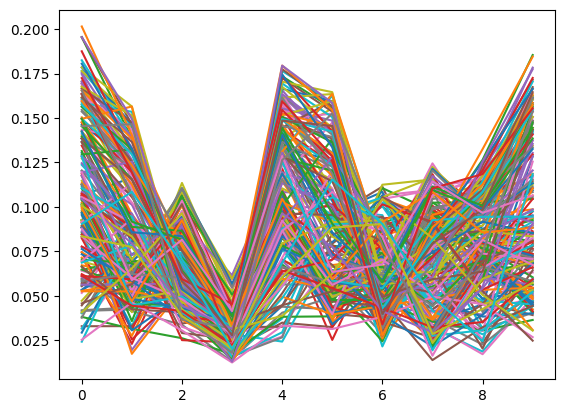

In [33]:
results_js[[col for col in results_js.columns if f'_{drift_detector}_value' in col]].iloc[:, :-1].plot(legend=False)
#plt.legend(bbox_to_anchor=(1, 0.5))

In [34]:
# figure = results.filter(column_names=results.continuous_column_names, methods=['jensen_shannon']).plot(kind='drift')
# figure.show()

In [35]:
# figure = results.filter(column_names=results.continuous_column_names, methods=['jensen_shannon']).plot(kind='distribution')
# figure.show()

### ADWIN detector

In [36]:
# # # using ADWIN drift detector to find the change points on each feature by iterating through every column of CT_dataset.full_df


# import time

# start_time = time.time()

# adwin = drift.ADWIN()
# all_drift = []

# for col in CT_dataset.full_df.columns:
#     adwin = drift.ADWIN()
#     feat = CT_dataset.full_df[col].iloc[:10000]
#     for i, val in enumerate(feat):
#         _ = adwin.update(val)
#         if adwin.drift_detected:
#             #print(f"Change detected at index {i}, input value: {val}")
#             all_drift.append(i)

# runtime = time.time() - start_time

In [37]:
# print(f"Runtime: {runtime/int(CT_dataset.full_df.shape[1]-2):.2f} seconds")

In [38]:
# plt.plot(results_js[[col for col in results_js.columns if '_jensen_shannon_value' in col]])

# for i in all_drift:
#     plt.axvline(x=int(i/1000), color='red', linestyle='--')

# plt.show()

In [39]:
# np.sort(all_drift)

### Own Jensen-Shannon

In [41]:
chg_points = [19000, 78000] # JS
# chg_points = [17439, 79000] # ADWIN

CT_dataset.add_changepoints(chg_points)
rad_left = 5000
rad_right = 5000

In [50]:

dde_exp_eq_radius = DDEffectExperiment(_dataset=CT_dataset)
dde_exp_eq_radius.changepoint_radius_driftscore(radius_left=rad_left, radius_right=rad_right)
# display(dde_exp_eq_radius.results_all)

start_time = time.time()
dde_exp_eq_radius.changepoint_radius_corr(radius_left=rad_left, radius_right=rad_right)
runtime1 = time.time() - start_time

with pd.ExcelWriter(f'measurements/final/monitored/insects/monitored_KS.xlsx') as writer:

    for chp in CT_dataset.change_points[:1]:
        drift_threshold = 0.15
        summary_df = pd.DataFrame(columns=['feat_1', 'feat_2', 'ref_corr', 'analysis_corr', 'corr_delta', 'feat_1_cd_score', 'feat_2_cd_score', 'delta_cd_score'])

        start_time2 = time.time()
        
        corr_df_delta = dde_exp_eq_radius.corr_scores[chp]['corr_delta']
        corr_df_analysis = dde_exp_eq_radius.corr_scores[chp]['analysis']
        corr_df_ref = dde_exp_eq_radius.corr_scores[chp]['reference']

        cd_score_df = dde_exp_eq_radius.results_all.loc[dde_exp_eq_radius.results_all['change_point']==chp].iloc[0]

        # combin!!!!
        for pair in itertools.combinations(dde_exp_eq_radius.dataset.full_df.columns, 2):
            feat1 = list(pair)[0]
            feat2 = list(pair)[1]

            if feat1 != feat2:
                summary_df.loc[len(summary_df.index)] = [feat1, feat2, np.abs(corr_df_ref.loc[feat1, feat2]), np.abs(corr_df_analysis.loc[feat1, feat2]), corr_df_delta.loc[feat1, feat2], cd_score_df[feat1], cd_score_df[feat2], np.abs(cd_score_df[feat1]-cd_score_df[feat2])]

        summary_df['feat_1_drift'] = np.where(summary_df['feat_1_cd_score']>drift_threshold, 1, 0)
        summary_df['feat_2_drift'] = np.where(summary_df['feat_2_cd_score']>drift_threshold, 1, 0)
        summary_df['single_feat_drift'] = np.where(summary_df['feat_1_drift'] ^ summary_df['feat_2_drift'], 1, 0)
        summary_df['feat_pair_drift'] = np.where(summary_df['feat_1_drift'] & summary_df['feat_2_drift'], 1, 0)
        
        runtime1 += time.time() - start_time2

        # print(f"Runtime: {runtime1:.2f} seconds")
        
        summary_df.to_excel(writer, sheet_name=f'{chp}', index=False)

14000 19000 24000
73000 78000 83000
14000 19000 24000
73000 78000 83000


#### Change point 1

In [51]:
summary_df = summary_df.sort_values(by=['feat_1_cd_score'], ascending=False)

In [52]:
summary_df

,feat_1,feat_2,ref_corr,analysis_corr,corr_delta,feat_1_cd_score,feat_2_cd_score,delta_cd_score,feat_1_drift,feat_2_drift,single_feat_drift,feat_pair_drift
19870,feat_118,feat_98,0.239795,0.378943,0.139148,0.316308,0.239485,0.076823,1,1,0,1
19869,feat_118,feat_181,0.054752,0.177399,0.122647,0.316308,0.079982,0.236326,1,0,1,0
19868,feat_118,feat_121,0.944283,0.920070,0.024213,0.316308,0.310222,0.006086,1,1,0,1
19867,feat_118,feat_169,0.118660,0.286789,0.168129,0.316308,0.043716,0.272592,1,0,1,0
19866,feat_118,feat_145,0.092069,0.277775,0.185706,0.316308,0.103352,0.212956,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
15651,feat_38,feat_133,0.191510,0.111415,0.080095,0.034524,0.142097,0.107573,0,0,0,0
15650,feat_38,feat_170,0.168313,0.162633,0.005680,0.034524,0.037218,0.002694,0,0,0,0
15649,feat_38,feat_63,0.131313,0.113218,0.018095,0.034524,0.242316,0.207792,0,1,1,0
15648,feat_38,feat_163,0.221117,0.206006,0.015111,0.034524,0.082712,0.048188,0,0,0,0


In [53]:
summary_df.feat_pair_drift.sum()

2145

In [54]:
def get_roc_auc(score, y):
    # false positive rate
    FPR = []
    # true positive rate
    TPR = []
    # Iterate thresholds from 0.0 to 1.0
    thresholds = np.arange(0.0, 1.01, 0.2)
    # array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

    # get number of positive and negative examples in the dataset
    P = sum(y)
    N = len(y) - P

    # iterate through all thresholds and determine fraction of true positives
    # and false positives found at this threshold
    for thresh in thresholds:
        FP=0
        TP=0
        thresh = round(thresh,2) #Limiting floats to two decimal points, or threshold 0.6 will be 0.6000000000000001 which gives FP=0
        for i in range(len(score)):
            if (score[i] >= thresh):
                if y[i] == 1:
                    TP = TP + 1
                if y[i] == 0:
                    FP = FP + 1
        FPR.append(FP/N)
        TPR.append(TP/P)

    auc = -1 * np.trapz(TPR, FPR)

    plt.plot(FPR, TPR, linestyle='--', marker='o', color='darkorange', lw = 2, label='ROC curve', clip_on=False)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve, AUC = %.2f'%auc)
    plt.legend(loc="lower right")
    plt.savefig('AUC_example.png')
    plt.show()

In [55]:
def plot_lift_curve(y_pred, y_val, step=0.01):

    #Define an auxiliar dataframe to plot the curve
    aux_lift = pd.DataFrame()
    #Create a real and predicted column for our new DataFrame and assign values
    aux_lift['real'] = y_val
    aux_lift['predicted'] = y_pred
    #Order the values for the predicted probability column:
    aux_lift.sort_values('predicted',ascending=False,inplace=True)

    #Create the values that will go into the X axis of our plot
    x_val = np.arange(step,1+step,step)
    #Calculate the ratio of ones in our data
    ratio_ones = aux_lift['real'].sum() / len(aux_lift)
    #Create an empty vector with the values that will go on the Y axis our our plot
    y_v = []

    #Calculate for each x value its correspondent y value
    for x in x_val:
        num_data = int(np.ceil(x*len(aux_lift))) #The ceil function returns the closest integer bigger than our number
        data_here = aux_lift.iloc[:num_data,:]   # ie. np.ceil(1.4) = 2
        ratio_ones_here = data_here['real'].sum()/len(data_here)
        y_v.append(ratio_ones_here / ratio_ones)

   #Plot the figure
    fig, axis = plt.subplots()
    fig.figsize = (40,40)
    axis.plot(x_val, y_v, 'g-', linewidth = 3, markersize = 5)
    axis.plot(x_val, np.ones(len(x_val)), 'k-')
    axis.set_xlabel('Proportion of sample')
    axis.set_ylabel('Lift')
    plt.title('Lift Curve')
    plt.show()

In [56]:
score = summary_df.ref_corr #np.array([0.8, 0.6, 0.4, 0.2])
y = summary_df.feat_pair_drift #np.array([1,0,1,0])

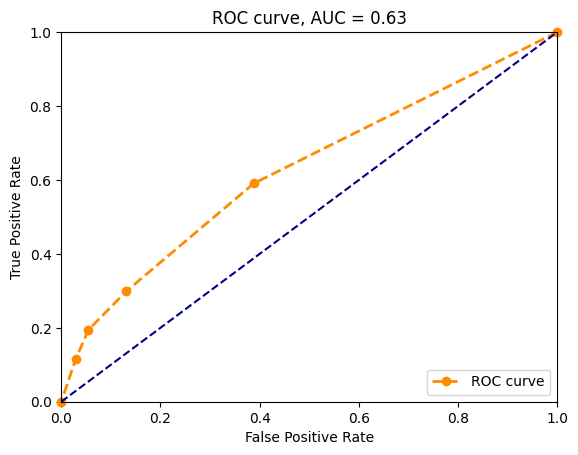

In [57]:
get_roc_auc(score, y)

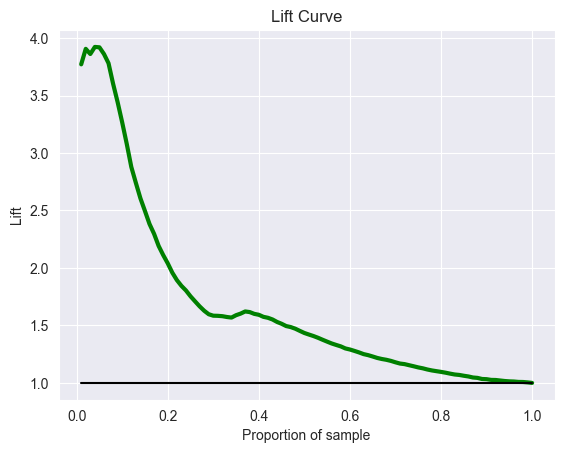

In [92]:
plot_lift_curve(score, y)

### DDE calculations

In [ ]:
summary_df

In [ ]:
m = 200
k_dde = (summary_df.feat_1_drift.sum() + summary_df.feat_2_drift.sum()) / (m-1)

In [ ]:
k_dde

In [ ]:
dde_df = pd.DataFrame()

In [ ]:
dde_df['threshold'] = np.arange(0,1,0.1)

In [ ]:
dde_df['num_corr_feat_pairs'] = dde_df.threshold.map(lambda t: summary_df[summary_df['ref_corr']>=t].shape[0])
dde_df['num_drifting_feat_pairs'] = dde_df.threshold.map(lambda t: summary_df[summary_df['ref_corr']>=t].feat_pair_drift.sum())
dde_df['dde_pr'] = m/k_dde * dde_df['num_drifting_feat_pairs']/dde_df['num_corr_feat_pairs']
dde_df['dde_lift'] = dde_df['dde_pr'] / dde_df.iloc[0].dde_pr

In [ ]:
dde_df

In [ ]:
dde_df[['dde_pr', 'dde_lift']].plot()

In [ ]:
dde_fitted_coeffs = np.polyfit(dde_df.threshold, dde_df.dde_lift, 2)
dde_fitted_curve = np.poly1d(dde_fitted_coeffs)

In [ ]:
plt.plot(dde_df.threshold, dde_df.dde_lift, 'o', dde_df.threshold, dde_fitted_curve(dde_df.threshold))
plt.show()

Excel ROC AUC calculations

In [ ]:
excel_data = pd.read_excel(r'C:\Users\MarcellNemeth\Documents\BME\phd\meresek\insects\CD_delta_vs_ro_chp_tabs_insects_drift1.xlsx', sheet_name='ROC_output')

In [ ]:
excel_data

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [ ]:
# calculate roc curves
fpr, tpr, thresholds = roc_curve(excel_data['real'], excel_data['check_10'])
auc = roc_auc_score(excel_data['real'], excel_data['check_10'])

# calculate AUC
plt.plot(fpr, tpr, marker='.', label='DDE method')
print('AUC: %.3f' % auc)

In [ ]:
# calculate roc curves
fpr, tpr, thresholds = roc_curve(excel_data['real'], excel_data['check_5'])
auc = roc_auc_score(excel_data['real'], excel_data['check_5'])

# calculate AUC
plt.plot(fpr, tpr, marker='.', label='DDE method')
print('AUC: %.3f' % auc)

In [ ]:
# calculate roc curves
fpr, tpr, thresholds = roc_curve(excel_data['real'], excel_data['check_3'])
auc = roc_auc_score(excel_data['real'], excel_data['check_3'])

# calculate AUC
plt.plot(fpr, tpr, marker='.', label='DDE method')
print('AUC: %.3f' % auc)

Crossvalidation of feature drift prediction

In [ ]:
# import random

In [ ]:
# d2_data = pd.read_excel(r'D:\Dokumentumok\BME\PhD\codes\dde\notebooks\outputs\insects\CD_delta_vs_ro_chp_tabs_insects_drift1.xlsx', sheet_name='d2')

In [ ]:
# drift_gt = pd.read_excel(r'D:\Dokumentumok\BME\PhD\codes\dde\notebooks\outputs\insects\CD_delta_vs_ro_chp_tabs_insects_drift1.xlsx', sheet_name='drift_gt2')

In [ ]:
# drift_gt = drift_gt.set_index('feature')

In [ ]:
# all_feats = [f'feat_{f}' for f in range(1, 201)]
#
# k_fold = 5
# max_num_check_feats = 190

In [ ]:
# cross_metrics = pd.DataFrame(index=pd.Index(all_feats))
# cross_metrics = cross_metrics.merge(drift_gt, left_index=True, right_index=True)
#
# for num_check_feats in range(1, max_num_check_feats+1):
#     for k in range(k_fold):
#         check_feats = [f'feat_{r}' for r in random.sample(range(1, 200), num_check_feats)]
#         filt_data = d2_data[(d2_data['feature_1'].isin(check_feats))]
#
#         dde_agg = filt_data.groupby('feature_2').agg({'feat2_drift_prob_local': 'sum'}).reset_index()
#         dde_agg = dde_agg.rename(columns={'feat2_drift_prob_local': f'chkfts{num_check_feats}_fold{k+1}'})
#         dde_agg = dde_agg.set_index('feature_2')
#
#         cross_metrics = cross_metrics.merge(dde_agg, left_index=True, right_index=True, how='left')
#         #cross_metrics = cross_metrics.fillna(cross_metrics.mean())

In [ ]:
# cross_metrics

In [ ]:
# cross_preds = pd.DataFrame(index=pd.Index(all_feats))
# cross_preds = cross_preds.merge(drift_gt, left_index=True, right_index=True)
#
# for num_check_feats in range(1, max_num_check_feats + 1):
#     for k in range(k_fold):
#         check_feats = [f'feat_{r}' for r in random.sample(range(1, 200), num_check_feats)]
#         filt_data = d2_data[(d2_data['feature_1'].isin(check_feats))]
#
#         dde_agg = filt_data.groupby('feature_2').agg({'feat_1_drift': 'mean'}).reset_index()
#         dde_agg = dde_agg.rename(columns={'feat_1_drift': f'chkfts{num_check_feats}_fold{k + 1}'})
#         dde_agg[f'chkfts{num_check_feats}_fold{k + 1}'] = dde_agg[f'chkfts{num_check_feats}_fold{k + 1}'].map(lambda x: 1 if x >= 0.5 else 0)
#
#         dde_agg = dde_agg.set_index('feature_2')
#
#         cross_preds = cross_preds.merge(dde_agg, left_index=True, right_index=True, how='left')

In [ ]:
# cross_preds = cross_preds.fillna(0).rename(columns={'drift_true': 'drift_gt'}) #.drop(columns=['drift_true'])

In [ ]:
# cross_preds

In [ ]:
# idx = cross_preds.columns.str.split('_', expand=True)

In [ ]:
# cross_preds.columns = pd.MultiIndex.from_tuples(idx)

In [ ]:
# cross_preds

In [ ]:
# preds_agg = pd.DataFrame(columns=cross_preds.columns[1:], index=pd.Index(pd.Series(['AUC'])))

In [ ]:
# preds_agg

In [ ]:
# for num_check_feats in range(1, max_num_check_feats + 1):
#     for k in range(k_fold):
#         # print(roc_auc_score(cross_preds['drift']['gt'], cross_preds[f'chkfts{num_check_feats}'][f'fold{k+1}']))
#         auc = roc_auc_score(cross_preds['drift']['gt'], cross_preds[f'chkfts{num_check_feats}'][f'fold{k+1}'])
#         preds_agg.loc['AUC', (f'chkfts{num_check_feats}', f'fold{k+1}')] = auc

In [ ]:
# preds_agg.mean(level=0, axis='columns').T.plot()

### Cross validation test on Excel extract - JS

In [5]:
import random
from itertools import zip_longest

In [6]:
from sklearn.metrics import roc_auc_score, roc_curve

In [7]:
def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """

    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    print(f'model 1 AUC score: {roc_auc_score(true_y, y_prob)}')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

In [8]:
d2_df = pd.read_excel(r'D:\Dokumentumok\BME\PhD\codes\dde\notebooks\outputs\insects\cross_valid_test.xlsx', sheet_name='d2')
feat_1_drift_gt = d2_df.groupby('feature_1').agg({'feat_1_drift': 'max'}).rename(columns={'feat_1_drift': 'drift_gt'})

In [9]:
measurement_df = pd.DataFrame(index=pd.Index(pd.Series(['f1_score'])))
measurement_df_probs = pd.DataFrame(index=pd.Index(pd.Series(['auc'])))
measurement_df_ddescore = pd.DataFrame(index=pd.Index(pd.Series(['auc'])))

In [16]:
max_num_chkfts = 10
num_kfold = 10

model 1 AUC score: 0.6010123239436619
model 1 AUC score: 0.606294014084507
model 1 AUC score: 0.6191681338028169
model 1 AUC score: 0.6340228873239436
model 1 AUC score: 0.6106954225352113
model 1 AUC score: 0.6105853873239436
model 1 AUC score: 0.6081646126760563
model 1 AUC score: 0.6068992077464789
model 1 AUC score: 0.6163072183098591
model 1 AUC score: 0.6022227112676056


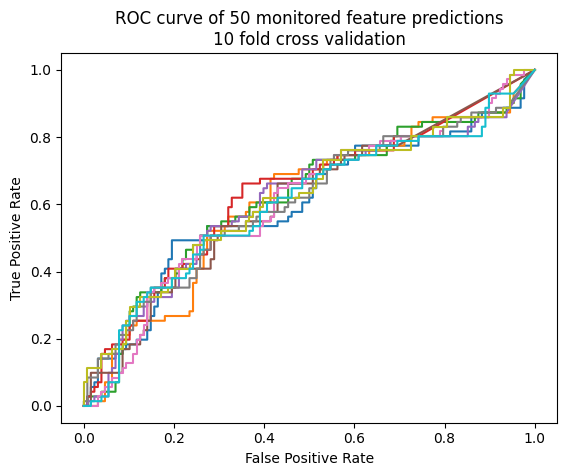

In [17]:
fprs = []
tprs = []

for num_chkfts in range(max_num_chkfts, max_num_chkfts+1):
    for k in range(1, num_kfold+1):
        feats_check = [f'feat_{r}' for r in random.sample(range(1, 200), num_chkfts)]
        d2_df_filt = d2_df[(d2_df['feature_2'].isin(feats_check))]

        d2_df_filt_agg = d2_df_filt.groupby('feature_1').agg({'feat_1_drift': 'sum', 'feat2_drift_prob_local': 'sum'})

        d2_df_filt_agg['pred_prob'] = d2_df_filt_agg['feat_1_drift'].map(lambda x: x/num_chkfts)
        d2_df_filt_agg['pred'] = d2_df_filt_agg['feat_1_drift'].map(lambda x: 1 if x / num_chkfts >= 0.5 else 0)

        feat_1_drift_gt = feat_1_drift_gt.merge(d2_df_filt_agg[['pred', 'pred_prob', 'feat2_drift_prob_local']], left_index=True, right_index=True, how='left')
        feat_1_drift_gt = feat_1_drift_gt.fillna(0)


        feat_1_drift_gt.sort_values(by='feat2_drift_prob_local', ascending=False, inplace=True)

        measurement_df[f'chkfeats{num_chkfts}_fold{k}'] = f1_score(feat_1_drift_gt['drift_gt'], feat_1_drift_gt['pred'])
        measurement_df_probs[f'chkfeats{num_chkfts}_fold{k}'] = roc_auc_score(feat_1_drift_gt['drift_gt'], feat_1_drift_gt['pred_prob'])
        measurement_df_ddescore[f'chkfeats{num_chkfts}_fold{k}'] = roc_auc_score(feat_1_drift_gt['drift_gt'], feat_1_drift_gt['feat2_drift_prob_local'])

        fpr, tpr, _ = roc_curve(feat_1_drift_gt['drift_gt'], feat_1_drift_gt['feat2_drift_prob_local'])
        fprs.append(fpr)
        tprs.append(tpr)

        plot_roc_curve(feat_1_drift_gt['drift_gt'], feat_1_drift_gt['feat2_drift_prob_local'])

        feat_1_drift_gt = feat_1_drift_gt.drop(columns=['pred', 'pred_prob', 'feat2_drift_prob_local'])

plt.title('ROC curve of 50 monitored feature predictions\n10 fold cross validation')
plt.show()

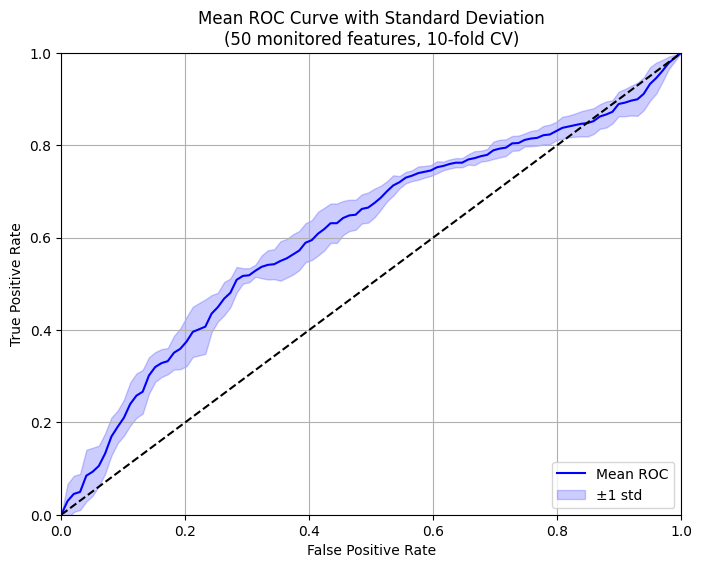

In [18]:
# plot the tprs and fprs on a plot, but average out them pointwise and show the std of each on a shaded plot
# Interpolate TPR values to have same FPR points
interp_fpr = np.linspace(0, 1, 100)
interp_tprs = []

for fpr, tpr in zip(fprs, tprs):
    interp_tpr = np.interp(interp_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    interp_tprs.append(interp_tpr)

# Calculate mean and std of TPR values
mean_tpr = np.mean(interp_tprs, axis=0)
std_tpr = np.std(interp_tprs, axis=0)

# Plot mean ROC curve with std shading
plt.figure(figsize=(8, 6))
plt.plot(interp_fpr, mean_tpr, 'b-', label='Mean ROC')
plt.fill_between(interp_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='b', alpha=0.2, label='±1 std')

plt.plot([0, 1], [0, 1], 'k--')  # Random classifier line
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate') 
plt.title('Mean ROC Curve with Standard Deviation\n(50 monitored features, 10-fold CV)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [53]:
fprs

[array([0.       , 0.0078125, 0.015625 , 0.015625 , 0.0390625, 0.0390625,
        0.046875 , 0.046875 , 0.0703125, 0.0703125, 0.078125 , 0.078125 ,
        0.0859375, 0.0859375, 0.109375 , 0.109375 , 0.1171875, 0.1171875,
        0.125    , 0.125    , 0.1328125, 0.1328125, 0.1484375, 0.1484375,
        0.1796875, 0.1796875, 0.234375 , 0.234375 , 0.2421875, 0.2421875,
        0.25     , 0.25     , 0.2578125, 0.2578125, 0.265625 , 0.265625 ,
        0.28125  , 0.28125  , 0.359375 , 0.359375 , 0.3828125, 0.3828125,
        0.390625 , 0.390625 , 0.3984375, 0.3984375, 0.40625  , 0.40625  ,
        0.421875 , 0.421875 , 0.4296875, 0.4296875, 0.4453125, 0.4453125,
        0.4609375, 0.4609375, 0.4921875, 0.4921875, 0.5078125, 0.5078125,
        0.5234375, 0.5234375, 0.53125  , 0.53125  , 0.5546875, 0.5546875,
        0.6171875, 0.6171875, 0.625    , 0.625    , 0.7109375, 0.7109375,
        0.71875  , 0.71875  , 0.8046875, 0.8046875, 0.8125   , 0.8125   ,
        0.828125 , 0.828125 , 0.859375

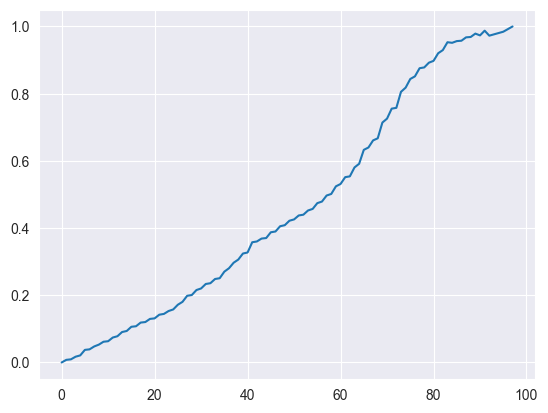

In [55]:
plt.plot(np.nanmean(np.array(list(zip_longest(*fprs)),dtype=float),axis=1))

In [44]:
    np.mean(fprs, axis=2)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (10,) + inhomogeneous part.

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (10,) + inhomogeneous part.

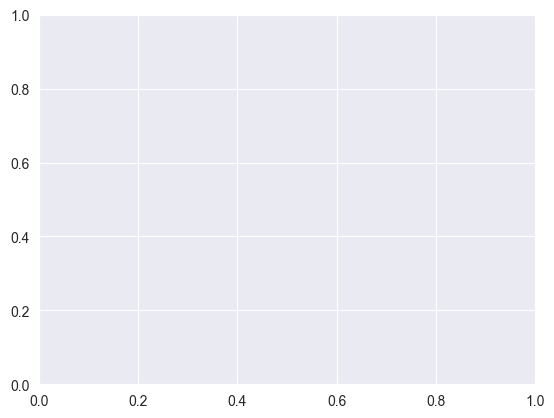

In [40]:
plt.plot(fprs,tprs)
plt.legend(loc=4)
plt.show()

In [28]:
measurement_df_ddescore

chkfeats1                                                              \
        fold1     fold2     fold3     fold4     fold5     fold6     fold7   
auc  0.528004  0.554302  0.556503  0.500825  0.519916  0.601893  0.589789   

                                   ... chkfeats199_fold1 chkfeats199_fold2  \
        fold8     fold9    fold10  ...                                       
auc  0.638644  0.582581  0.535211  ...          0.619278          0.619278   

    chkfeats199_fold3 chkfeats199_fold4 chkfeats199_fold5 chkfeats199_fold6  \
                                                                              
auc          0.619278          0.619278          0.619278          0.619278   

    chkfeats199_fold7 chkfeats199_fold8 chkfeats199_fold9 chkfeats199_fold10  
                                                                              
auc          0.619278          0.619278          0.619278           0.619278  

[1 rows x 3980 columns]

In [29]:
idx = measurement_df.columns.str.split('_', expand=True)
measurement_df.columns = pd.MultiIndex.from_tuples(idx)

idx_probs = measurement_df_probs.columns.str.split('_', expand=True)
measurement_df_probs.columns = pd.MultiIndex.from_tuples(idx_probs)

idx_dde = measurement_df_ddescore.columns.str.split('_', expand=True)
measurement_df_ddescore.columns = pd.MultiIndex.from_tuples(idx_dde)

AttributeError: Can only use .str accessor with Index, not MultiIndex

In [30]:
measurement_df

chkfeats1                                                          \
             fold1     fold2     fold3     fold4     fold5 fold6     fold7   
f1_score  0.765217  0.621359  0.992908  0.806723  0.106667  0.58  0.456522   

                                       ... chkfeats199_fold1  \
             fold8    fold9    fold10  ...                     
f1_score  0.806723  0.43956  0.948148  ...          0.775862   

         chkfeats199_fold2 chkfeats199_fold3 chkfeats199_fold4  \
                                                                 
f1_score          0.775862          0.775862          0.775862   

         chkfeats199_fold5 chkfeats199_fold6 chkfeats199_fold7  \
                                                                 
f1_score          0.775862          0.775862          0.775862   

         chkfeats199_fold8 chkfeats199_fold9 chkfeats199_fold10  
                                                                 
f1_score          0.775862          0.775862           0.775862  

[1 rows x 3980 columns]

In [13]:
measurement_agg = pd.DataFrame()
measurement_agg['f1_avg'] = measurement_df.mean(level=0, axis='columns').T
measurement_agg['f1_std'] = measurement_df.std(level=0, axis='columns').T


with pd.ExcelWriter(r'D:\Dokumentumok\BME\PhD\codes\dde\notebooks\outputs\insects\measurement_agg.xlsx', engine='openpyxl', mode='w') as writer:
     measurement_agg.to_excel(writer, sheet_name='JS_agg')

measurement_agg_probs = pd.DataFrame()
measurement_agg_probs['auc_avg'] = measurement_df_probs.mean(level=0, axis='columns').T
measurement_agg_probs['auc_std'] = measurement_df_probs.std(level=0, axis='columns').T

with pd.ExcelWriter(r'D:\Dokumentumok\BME\PhD\codes\dde\notebooks\outputs\insects\measurement_agg.xlsx', engine='openpyxl', mode='a') as writer:
     measurement_agg_probs.to_excel(writer, sheet_name='JS_probs_agg')

measurement_agg_dde = pd.DataFrame()
measurement_agg_dde['auc_avg'] = measurement_df_ddescore.mean(level=0, axis='columns').T
measurement_agg_dde['auc_std'] = measurement_df_ddescore.std(level=0, axis='columns').T

with pd.ExcelWriter(r'D:\Dokumentumok\BME\PhD\codes\dde\notebooks\outputs\insects\measurement_agg.xlsx', engine='openpyxl', mode='a') as writer:
     measurement_agg_dde.to_excel(writer, sheet_name='JS_dde_agg')

<AxesSubplot:>

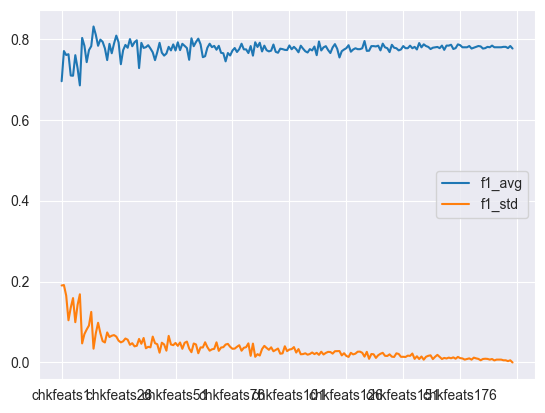

In [14]:
measurement_agg.plot()

<AxesSubplot:>

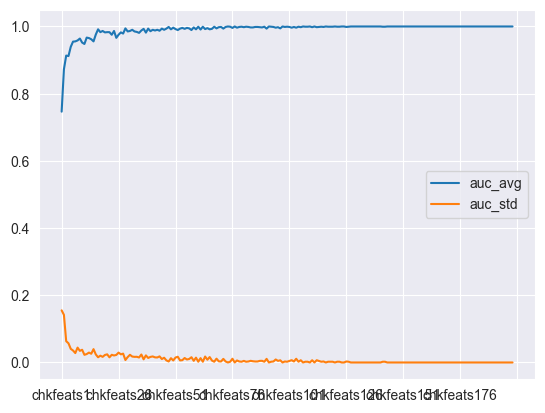

In [27]:
measurement_agg_probs.plot()

<AxesSubplot:>

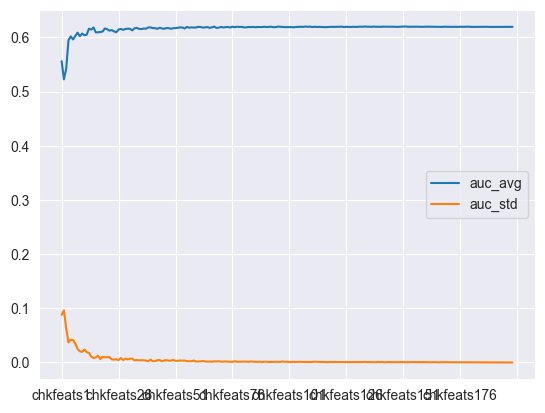

In [28]:
measurement_agg_dde.plot()

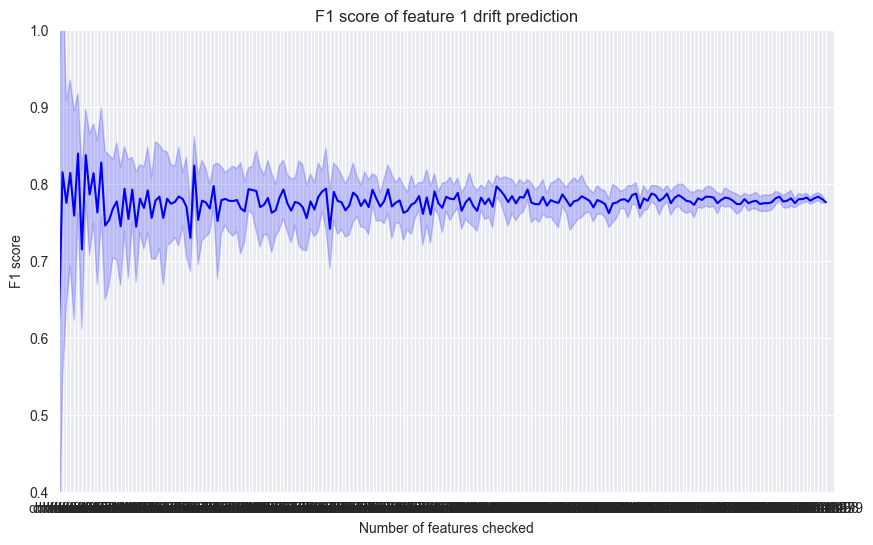

In [29]:
# plot mean with std on shaded area
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(measurement_agg['f1_avg'], color='blue')
ax.fill_between(measurement_agg.index, measurement_agg['f1_avg'] - measurement_agg['f1_std'], measurement_agg['f1_avg'] + measurement_agg['f1_std'], color='blue', alpha=0.2)
ax.set_xlabel('Number of features checked')
ax.set_ylabel('F1 score')
ax.set_title('F1 score of feature 1 drift prediction')
ax.set_ylim(0.4, 1)
ax.set_xlim(0, 200)
plt.show()

### Cross validation test on Excel extract - ADWIN

In [34]:
d2_df = pd.read_excel(r'D:\Dokumentumok\BME\PhD\codes\dde\notebooks\outputs\insects\CD_delta_vs_ro_chp_tabs_insects_adwin.xlsx',
                      sheet_name='d2')

In [35]:
feat_1_drift_gt = d2_df.groupby('feature_1').agg({'feat_1_drift': 'max'}).rename(columns={'feat_1_drift': 'drift_gt'})
measurement_df = pd.DataFrame(index=pd.Index(pd.Series(['f1_score'])))
measurement_df_probs = pd.DataFrame(index=pd.Index(pd.Series(['auc'])))
measurement_df_ddescore = pd.DataFrame(index=pd.Index(pd.Series(['auc'])))
max_num_chkfts = 199
num_kfold = 10


for num_chkfts in range(1, max_num_chkfts + 1):
    for k in range(1, num_kfold + 1):
        feats_check = [f'feat_{r}' for r in random.sample(range(1, 200), num_chkfts)]
        d2_df_filt = d2_df[(d2_df['feature_2'].isin(feats_check))]

        d2_df_filt_agg = d2_df_filt.groupby('feature_1').agg({'feat_1_drift': 'sum', 'feat2_drift_prob_local': 'sum'})

        d2_df_filt_agg['pred_prob'] = d2_df_filt_agg['feat_1_drift'].map(lambda x: x / num_chkfts)
        d2_df_filt_agg['pred'] = d2_df_filt_agg['feat_1_drift'].map(lambda x: 1 if x / num_chkfts >= 0.5 else 0)

        feat_1_drift_gt = feat_1_drift_gt.merge(d2_df_filt_agg[['pred', 'pred_prob', 'feat2_drift_prob_local']],
                                                left_index=True, right_index=True, how='left')
        feat_1_drift_gt = feat_1_drift_gt.fillna(0)

        feat_1_drift_gt.sort_values(by='feat2_drift_prob_local', ascending=False, inplace=True)

        measurement_df[f'chkfeats{num_chkfts}_fold{k}'] = f1_score(feat_1_drift_gt['drift_gt'], feat_1_drift_gt['pred'])
        measurement_df_probs[f'chkfeats{num_chkfts}_fold{k}'] = roc_auc_score(feat_1_drift_gt['drift_gt'],
                                                                              feat_1_drift_gt['pred_prob'])
        measurement_df_ddescore[f'chkfeats{num_chkfts}_fold{k}'] = roc_auc_score(feat_1_drift_gt['drift_gt'],
                                                                                 feat_1_drift_gt[
                                                                                     'feat2_drift_prob_local'])

        #plot_roc_curve(feat_1_drift_gt['drift_gt'], feat_1_drift_gt['pred_prob'])

        feat_1_drift_gt = feat_1_drift_gt.drop(columns=['pred', 'pred_prob', 'feat2_drift_prob_local'])


idx = measurement_df.columns.str.split('_', expand=True)
measurement_df.columns = pd.MultiIndex.from_tuples(idx)

idx_probs = measurement_df_probs.columns.str.split('_', expand=True)
measurement_df_probs.columns = pd.MultiIndex.from_tuples(idx_probs)

idx_dde = measurement_df_ddescore.columns.str.split('_', expand=True)
measurement_df_ddescore.columns = pd.MultiIndex.from_tuples(idx_dde)
measurement_agg = pd.DataFrame()
measurement_agg['f1_avg'] = measurement_df.mean(level=0, axis='columns').T
measurement_agg['f1_std'] = measurement_df.std(level=0, axis='columns').T

with pd.ExcelWriter(r'D:\Dokumentumok\BME\PhD\codes\dde\notebooks\outputs\insects\measurement_agg.xlsx', engine='openpyxl', mode='a') as writer:
     measurement_agg.to_excel(writer, sheet_name='ADWIN_agg')

measurement_agg_probs = pd.DataFrame()
measurement_agg_probs['auc_avg'] = measurement_df_probs.mean(level=0, axis='columns').T
measurement_agg_probs['auc_std'] = measurement_df_probs.std(level=0, axis='columns').T

with pd.ExcelWriter(r'D:\Dokumentumok\BME\PhD\codes\dde\notebooks\outputs\insects\measurement_agg.xlsx', engine='openpyxl', mode='a') as writer:
     measurement_agg_probs.to_excel(writer, sheet_name='ADWIN_probs_agg')

measurement_agg_dde = pd.DataFrame()
measurement_agg_dde['auc_avg'] = measurement_df_ddescore.mean(level=0, axis='columns').T
measurement_agg_dde['auc_std'] = measurement_df_ddescore.std(level=0, axis='columns').T

with pd.ExcelWriter(r'D:\Dokumentumok\BME\PhD\codes\dde\notebooks\outputs\insects\measurement_agg.xlsx', engine='openpyxl', mode='a') as writer:
     measurement_agg_dde.to_excel(writer, sheet_name='ADWIN_dde_agg')

PermissionError: [Errno 13] Permission denied: 'D:\\Dokumentumok\\BME\\PhD\\codes\\dde\\notebooks\\outputs\\insects\\measurement_agg.xlsx'

In [ ]:
measurement_agg.plot()
measurement_agg_probs.plot()
measurement_agg_dde.plot()

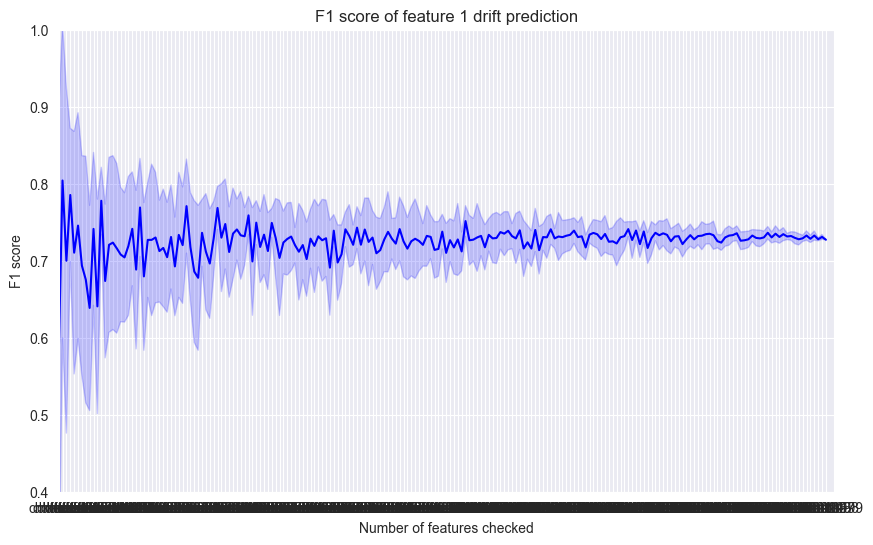

In [33]:
# plot mean with std on shaded area
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(measurement_agg['f1_avg'], color='blue')
ax.fill_between(measurement_agg.index, measurement_agg['f1_avg'] - measurement_agg['f1_std'],
                measurement_agg['f1_avg'] + measurement_agg['f1_std'], color='blue', alpha=0.2)
ax.set_xlabel('Number of features checked')
ax.set_ylabel('F1 score')
ax.set_title('F1 score of feature 1 drift prediction')
ax.set_ylim(0.4, 1)
ax.set_xlim(0, 200)
plt.show()